In [11]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import autoroot
from rs_tools._src.geoprocessing.goes.reproject import add_goes16_crs
from rs_tools._src.geoprocessing.msg.reproject import add_msg_crs
from rs_tools._src.geoprocessing.interp import resample_rioxarray

##### Load xarray datasets

In [2]:
goes_path = '/mnt/disks/data/miniset-full-disk/goes16/geoprocessed'
msg_path = '/mnt/disks/data/miniset-full-disk/msg/geoprocessed'

In [3]:
msg_files = [os.path.join(msg_path, f) for f in os.listdir(msg_path) if f.endswith('.nc')]
goes_files = [os.path.join(goes_path, f) for f in os.listdir(goes_path) if f.endswith('.nc')]

In [4]:
msg_files[0], goes_files[0]

('/mnt/disks/data/miniset-full-disk/msg/geoprocessed/20201023141244_msg.nc',
 '/mnt/disks/data/miniset-full-disk/goes16/geoprocessed/20201023170019_goes16.nc')

In [5]:
msg_ds = xr.open_dataset(msg_files[0])
goes_ds = xr.open_dataset(goes_files[0])

#### Reset coordinates to variables and remove latitude/longitude so that the reprojection works.

In [14]:
# Move specific coordinate variables to data variables
goes_ds = goes_ds.reset_coords(["cloud_mask"])
goes_ds = goes_ds.drop_vars(["latitude", "longitude"])

goes_ds = add_goes16_crs(goes_ds)

goes_ds.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True)

<xarray.Dataset> Size: 8GB
Dimensions:                 (band: 16, y: 10848, x: 10848, time: 1,
                             band_wavelength: 16)
Coordinates:
  * x                       (x) float32 43kB -5.434e+06 -5.433e+06 ... 5.434e+06
  * y                       (y) float32 43kB 5.434e+06 5.433e+06 ... -5.434e+06
  * time                    (time) <U16 64B '2020-10-23 17:05'
  * band_wavelength         (band_wavelength) float32 64B 0.47 0.64 ... 13.27
    goes_imager_projection  int64 8B 0
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
Data variables:
    Rad                     (band, y, x) float32 8GB ...
    cloud_mask              (y, x) float32 471MB ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-23T17:09:56.2Z
    time_coverage_start:       2020-10-23T17:00:19.9Z
    time_coverage_end:         2020-10-23T17:09:50.7Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        6e83ad9e-cfb1-4a7a-9190-8db286368cfe

In [15]:
# Move specific coordinate variables to data variables
msg_ds = msg_ds.reset_coords(["cloud_mask"])
msg_ds = msg_ds.drop_vars(["latitude", "longitude"])

msg_ds = add_msg_crs(msg_ds)

msg_ds.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True)



<xarray.Dataset> Size: 717MB
Dimensions:             (y: 3712, x: 3712, band: 11, time: 1,
                         band_wavelength: 11)
Coordinates:
    msg_seviri_fes_3km  int64 8B 0
  * y                   (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.569e+06
  * x                   (x) float64 30kB 5.566e+06 5.563e+06 ... -5.569e+06
  * band                (band) <U6 264B 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * time                (time) <U19 76B '2020-10-23 14:00:00'
  * band_wavelength     (band_wavelength) float64 88B 1.64 3.92 ... 6.25 7.35
Data variables:
    cloud_mask          (y, x) float64 110MB ...
    Rad                 (band, y, x) float32 606MB ...
Attributes:
    calibration:         radiance
    standard_name:       toa_outgoing_radiance_per_unit_wavenumber
    platform_name:       Meteosat-11
    sensor:              seviri
    units:               mW m-2 sr-1 (cm-1)-1
    orbital_parameters:  {"projection_longitude": 0.0, "projection_latitude":...

#### Resample GOES to speed up processing

In [19]:
from rasterio.enums import Resampling

src_resolution = 3_000
resampling = Resampling.bilinear

goes_ds_sub = goes_ds.rio.reproject(
    goes_ds.rio.crs, 
    resolution = src_resolution, 
    resample = resampling
)

## Reprojection 101

**TODO**

* Reprojection
* Clip Bounding Box

**THINGS WE NEED**

* CRS
* Transform
* Bounds
* Geometry (Polygon, BoundingBox, FootPrint, etc)

In [55]:
msg_ds = add_msg_crs(msg_ds)
# CRS
src_crs = msg_ds.rio.crs
print(f"CRS:\n{src_crs}\n")

# bounds
src_bounds = msg_ds.rio.bounds()
print(f"Bounds:\n{src_bounds}\n")

# resolution
src_resolution = msg_ds.rio.resolution()
print(f"Resolution:\n{src_resolution}\n")

# transformation
src_transform = msg_ds.rio.transform()
print(f"Transform:\n{src_transform}\n")

CRS:
PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6378169,295.488065897014]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",0],PARAMETER["satellite_height",35785831],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Bounds:
(-5570248.477339745, -5567248.074173927, 5567248.074173927, 5570248.477339745)

Resolution:
(-3000.4031658172607, 3000.4031658172607)

Transform:
|-3000.40, 0.00, 5567248.07|
| 0.00, 3000.40,-5567248.07|
| 0.00, 0.00, 1.00|



In [56]:
goes_ds = add_goes16_crs(goes_ds)
# CRS
src_crs = goes_ds.rio.crs
print(f"CRS:\n{src_crs}\n")

# bounds
src_bounds = goes_ds.rio.bounds()
print(f"Bounds:\n{src_bounds}\n")

# resolution
src_resolution = goes_ds.rio.resolution()
print(f"Resolution:\n{src_resolution}\n")

# transformation
src_transform = goes_ds.rio.transform()
print(f"Transform:\n{src_transform}\n")

CRS:
PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257222096042]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-75],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=geos +sweep=x +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs"]]

Bounds:
(-5434895.004332995, -5434895.004332995, 5434895.004332995, 5434895.004332995)

Resolution:
(1002.0086659905965, -1002.0086659905965)

Transform:
| 1002.01, 0.00,-5434895.00|
| 0.00,-1002.01, 5434895.00|
| 0.00, 0.00, 1.00|



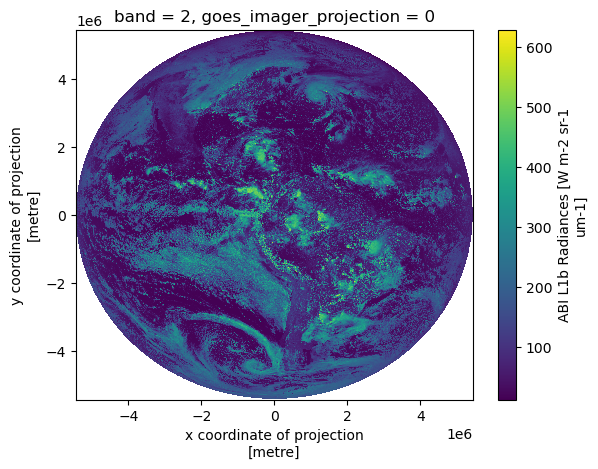

In [21]:
goes_ds_sub.Rad.isel(band=1).plot()

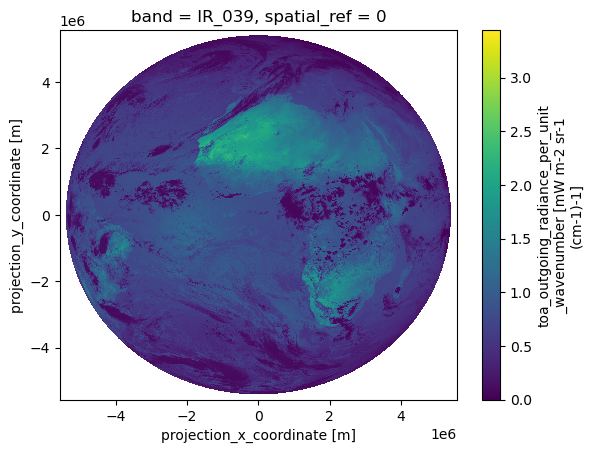

In [11]:
msg_ds.Rad.isel(band=1).plot()

### Reproject I - SOLO

#### Reproject to an arbitrary coordinate reference frame

In [22]:
from pyproj import CRS

dst_crs = CRS.from_epsg(4326)  # WGS 84
dst_resolution = 0.25 # in your destination units, in this case degrees

In [23]:
goes_ds_sub_geo_reproject = goes_ds_sub.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
goes_ds_sub_geo_reproject

<xarray.Dataset> Size: 26MB
Dimensions:                 (x: 650, y: 598, band: 16)
Coordinates:
  * x                       (x) float64 5kB -156.1 -155.9 -155.6 ... 5.851 6.101
  * y                       (y) float64 5kB 74.49 74.24 73.99 ... -74.51 -74.76
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 25MB nan nan nan ... nan nan
    cloud_mask              (y, x) float32 2MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-23T17:09:56.2Z
    time_coverage_start:       2020-10-23T17:00:19.9Z
    time_coverage_end:         2020-10-23T17:09:50.7Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        6e83ad9e-cfb1-4a7a-9190-8db286368cfe

In [26]:
msg_ds_geo_reproject = msg_ds.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
msg_ds_geo_reproject

<xarray.Dataset> Size: 20MB
Dimensions:             (x: 651, y: 593, band: 11)
Coordinates:
  * x                   (x) float64 5kB -81.16 -80.91 -80.66 ... 81.09 81.34
  * y                   (y) float64 5kB 74.05 73.8 73.55 ... -73.45 -73.7 -73.95
    msg_seviri_fes_3km  int64 8B 0
  * band                (band) <U6 264B 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
Data variables:
    cloud_mask          (y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    Rad                 (band, y, x) float32 17MB nan nan nan ... nan nan nan
Attributes:
    calibration:         radiance
    standard_name:       toa_outgoing_radiance_per_unit_wavenumber
    platform_name:       Meteosat-11
    sensor:              seviri
    units:               mW m-2 sr-1 (cm-1)-1
    orbital_parameters:  {"projection_longitude": 0.0, "projection_latitude":...

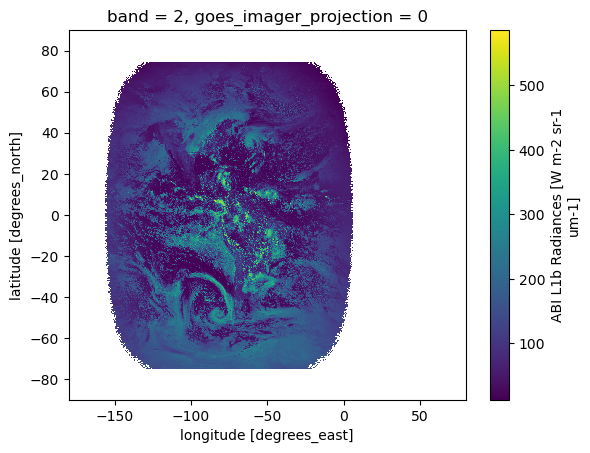

In [24]:
goes_ds_sub_geo_reproject.Rad.isel(band=1).plot() # Not sure why the plot is cut off
plt.ylim(-90, 90);
plt.xlim(-180, 80);

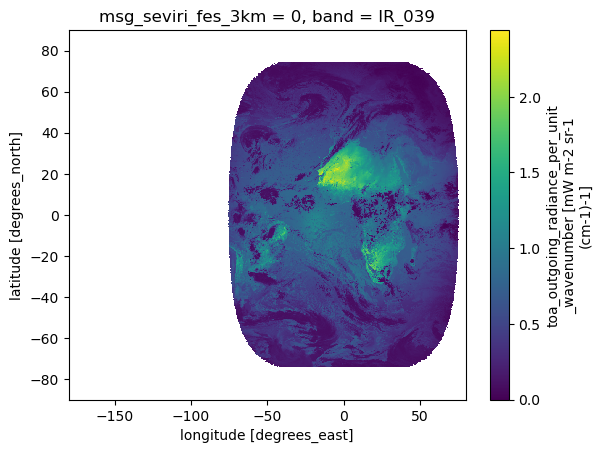

In [27]:
msg_ds_geo_reproject.Rad.isel(band=1).plot()
plt.ylim(-90, 90);
plt.xlim(-180, 80);

(-180.0, 80.0)

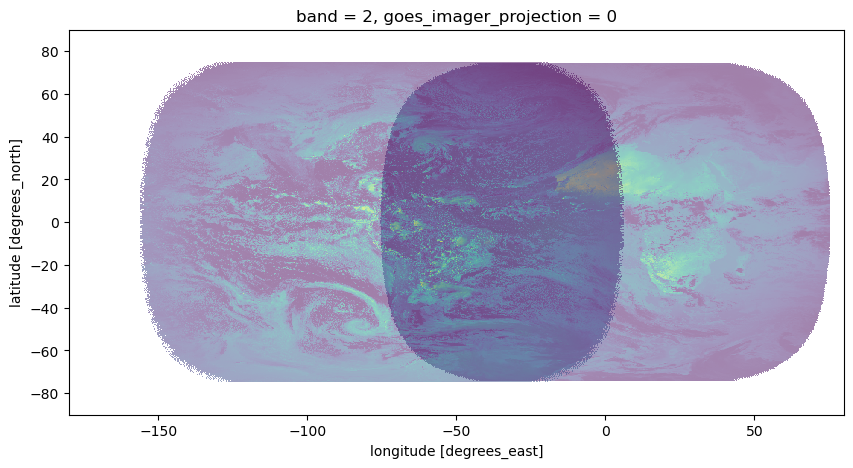

In [31]:
plt.figure(figsize=(10, 5))
msg_ds_geo_reproject.Rad.isel(band=1).plot(alpha=0.5, add_colorbar=False)
goes_ds_sub_geo_reproject.Rad.isel(band=1).plot(alpha=0.5, add_colorbar=False)
# suppress color bars
plt.ylim(-90, 90)
plt.xlim(-180, 80)

### Reprojection II
Project GOES into MSG reference frame

In [50]:
from pyproj import CRS

dst_crs = msg_ds.rio.crs
dst_resolution = msg_ds.rio.resolution()[1] # in your destination units, in this case degrees

In [51]:
goes_ds_sub_reproject_msg = goes_ds_sub.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
goes_ds_sub_reproject_msg

<xarray.Dataset> Size: 494MB
Dimensions:                 (x: 2029, y: 3577, band: 16)
Coordinates:
  * x                       (x) float64 16kB -5.433e+06 -5.43e+06 ... 6.521e+05
  * y                       (y) float64 29kB 5.363e+06 5.36e+06 ... -5.367e+06
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 464MB 0.0 0.0 0.0 ... nan nan
    cloud_mask              (y, x) float32 29MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-23T17:09:56.2Z
    time_coverage_start:       2020-10-23T17:00:19.9Z
    time_coverage_end:         2020-10-23T17:09:50.7Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        6e83ad9e-cfb1-4a7a-9190-8db286368cfe

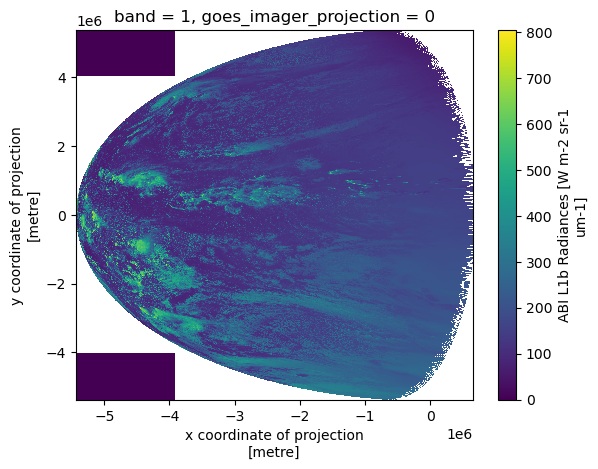

In [52]:
goes_ds_sub_reproject_msg.Rad.sel(band=1).plot()

### Reprojection III
Cut GOES data outside MSG field-of-view

In [93]:
from pyproj import CRS
from shapely import box

dst_crs = msg_ds.rio.crs
dst_bounds = msg_ds.rio.bounds
dst_resolution = msg_ds.rio.resolution()[1] # in your destination units, in this case degrees

# extract bounding box
bbox = box(*msg_ds.rio.bounds())

# .clip(geometries=geometries,
geometries = [bbox]

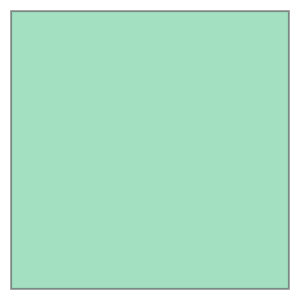

In [94]:
bbox

In [95]:
goes_ds_sub_msg = goes_ds_sub.rio.reproject_match(msg_ds)

In [96]:
goes_ds_sub_msg

<xarray.Dataset> Size: 937MB
Dimensions:                 (band: 16, x: 3712, y: 3712)
Coordinates:
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
  * x                       (x) float64 30kB 5.566e+06 5.563e+06 ... -5.569e+06
  * y                       (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.569e+06
Data variables:
    Rad                     (band, y, x) float32 882MB 0.0 0.0 0.0 ... 0.0 0.0
    cloud_mask              (y, x) float32 55MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-23T17:09:56.2Z
    time_coverage_start:       2020-10-23T17:00:19.9Z
    time_coverage_end:         2020-10-23T17:09:50.7Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        6e83ad9e-cfb1-4a7a-9190-8db286368cfe

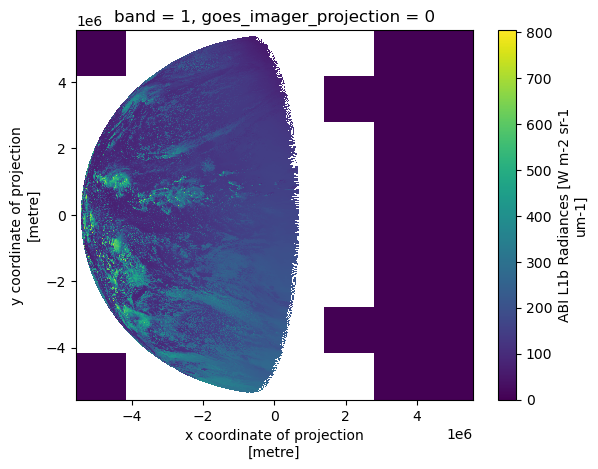

In [97]:
goes_ds_sub_msg.Rad.sel(band=1).plot() # It's not clear why these artifacts are added

##### Clip to common field-of-view
1. Grab the geometries of each dataset (MSG & GOES)
2. Take the intersection between MSG & GOES
3. Use that to clip

In [98]:
# Extract the bounding boxes of the two datasets
bbox1 = box(*msg_ds.rio.bounds())
bbox2 = box(*goes_ds_sub_reproject_msg.rio.bounds())

# Find the intersection of the two bounding boxes
intersection_bbox = bbox1.intersection(bbox2)

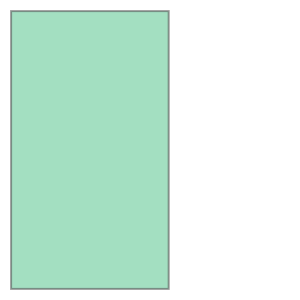

In [99]:
bbox2

In [100]:
out = goes_ds_sub_reproject_msg.rio.clip_box(*intersection_bbox.bounds, crs=msg_ds.rio.crs)

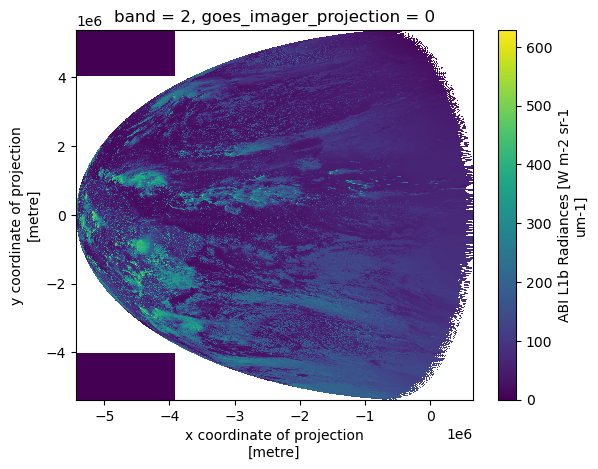

In [101]:
out.Rad.isel(band=1).plot() # Looks the same as before

In [102]:
dst_crs = CRS.from_epsg(4326)  # WGS 84
dst_resolution = 0.25 # in your destination units, in this case degrees
out_geo_reproject = out.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
out_geo_reproject

<xarray.Dataset> Size: 19MB
Dimensions:                 (x: 444, y: 628, band: 16)
Coordinates:
  * x                       (x) float64 4kB -81.15 -80.9 -80.65 ... 29.35 29.6
  * y                       (y) float64 5kB 78.17 77.92 77.67 ... -78.33 -78.58
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 18MB nan nan nan ... nan nan
    cloud_mask              (y, x) float32 1MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-23T17:09:56.2Z
    time_coverage_start:       2020-10-23T17:00:19.9Z
    time_coverage_end:         2020-10-23T17:09:50.7Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        6e83ad9e-cfb1-4a7a-9190-8db286368cfe

(-90.0, 90.0)

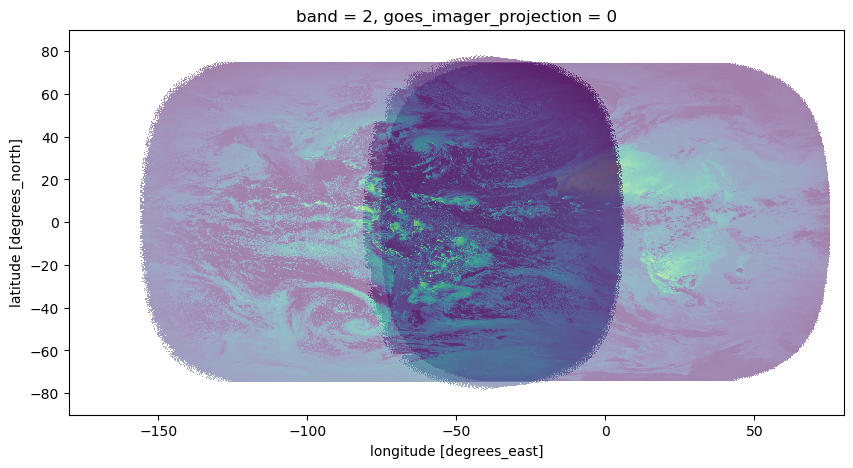

In [104]:
plt.figure(figsize=(10, 5))
msg_ds_geo_reproject.Rad.isel(band=1).plot(alpha=0.5, add_colorbar=False)
goes_ds_sub_geo_reproject.Rad.isel(band=1).plot(alpha=0.5, add_colorbar=False)
out_geo_reproject.Rad.isel(band=1).plot(alpha=0.5, add_colorbar=False)
# suppress color bars
plt.xlim(-180, 80)
plt.ylim(-90, 90)